In [1]:
# basics
import os
import pandas as pd
import numpy as np
import missingno as msno

# plots
import  matplotlib.pyplot as  plt
import matplotlib.patches as mpatches
import seaborn as sns

# statistics plots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot

# statistical tests and auto arima
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
from pmdarima.arima import auto_arima
#from arch import arch_model
from statsmodels.tsa.api import VAR

# metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
os.chdir('../..')

# 1. Data load and short EDA

In [3]:
df = pd.read_csv('data/data_nominal_clean.csv', sep=';',  index_col='date',  parse_dates=['date'])
dfr = pd.read_csv('data/data_returns_clean.csv', sep=';',  index_col='date',  parse_dates=['date']).dropna()
display(df.head())
display(dfr.head())

,Gold,CrudeOil,S&P500,FTSE250
date,,,,
1986-01-02,326.30,25.56,209.59,1417.26
1986-01-03,326.75,26.00,210.88,1424.61
1986-01-06,328.00,26.53,210.65,1430.96
1986-01-07,330.00,25.85,213.80,1421.22
1986-01-08,332.60,25.87,207.97,1408.79


,Gold,CrudeOil,S&P500,FTSE250
date,,,,
1986-01-03,0.001379,0.017214,0.006155,0.005186
1986-01-06,0.003826,0.020385,-0.001091,0.004457
1986-01-07,0.006098,-0.025631,0.014954,-0.006807
1986-01-08,0.007879,0.000774,-0.027268,-0.008746
1986-01-09,0.002706,0.006185,-0.008944,-0.013941


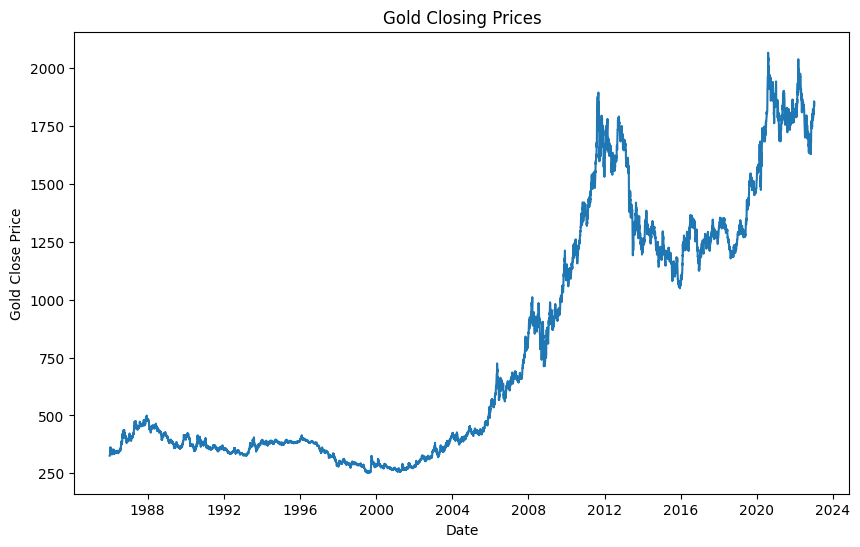

In [4]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Gold Close Price')
plt.plot(df['Gold'])
plt.title('Gold Closing Prices')
plt.show()

<AxesSubplot: ylabel='Density'>

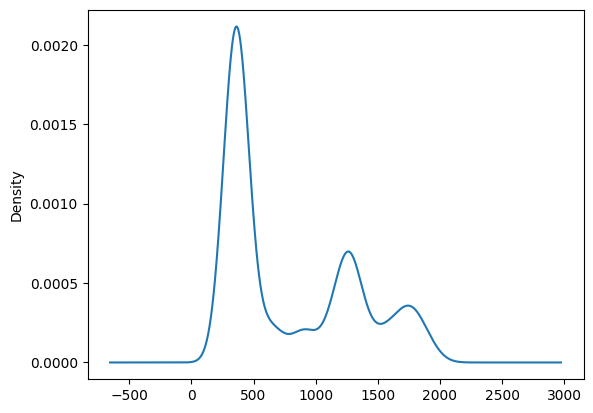

In [5]:
df.Gold.plot(kind='kde')

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


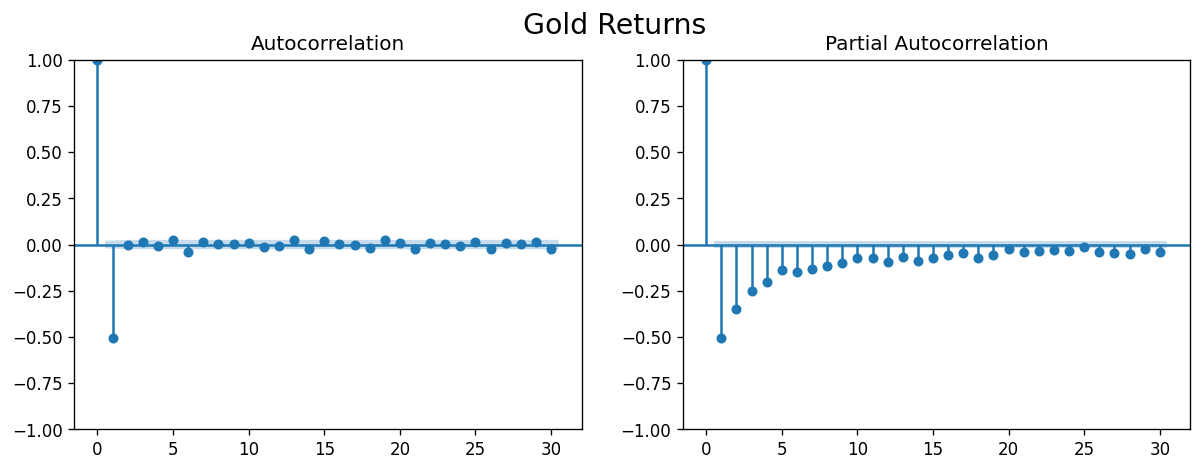

In [6]:
dfac = dfr.copy()
dfac.reset_index(inplace=True, drop=True)

plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
fig.suptitle('Gold Returns', fontsize=17)
plot_acf(dfac['Gold'].diff().dropna(), ax=axes[0], lags=30)
plot_pacf(dfac['Gold'].diff().dropna(), ax=axes[1], lags=30)

plt.show()

In [7]:
testr = adfuller(dfr.Gold)
testr[0]

-20.55856964871466

In [8]:
def plot_test_stationarity(subplot, timeseries, name):
    
    adf = adfuller(timeseries,autolag='AIC')
    jb = stats.jarque_bera(timeseries)
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    #Plot rolling statistics:
    subplot.plot(timeseries, color='lightblue',label='Original')
    subplot.plot(rolmean, color='red', label='Rolling Mean')
    subplot.plot(rolstd, color='black', label = 'Rolling Std')
    subplot.title.set_text(f'{name}\nADF -> Test Statistic: {round(adf[0],2)}, p-value: {round(adf[1],2)}\nJarque Bera -> Test statistic {round(jb[0],2)}, p-value:{jb[1]}')
    
    return plt

In [9]:
def plotall(df):
        blue_patch = mpatches.Patch(color='lightblue', label='Original')
        red_patch = mpatches.Patch(color='red', label='Rolling Mean')
        black_patch = mpatches.Patch(color='black', label='Rolling Std')

        fig, subplots = plt.subplots(nrows=4, ncols=1, figsize=(12,24))
        fig.suptitle("Rolling Means and Standard Deviations", fontsize=20, x=0.35, y=0.95)
        fig.legend(handles=[red_patch, blue_patch, black_patch], bbox_to_anchor=(0.9,0.95))

        for cname, subplot in zip(df.columns,subplots):
                plot_test_stationarity(subplot, df[cname], cname)

        plt.show()
        plt.clf()

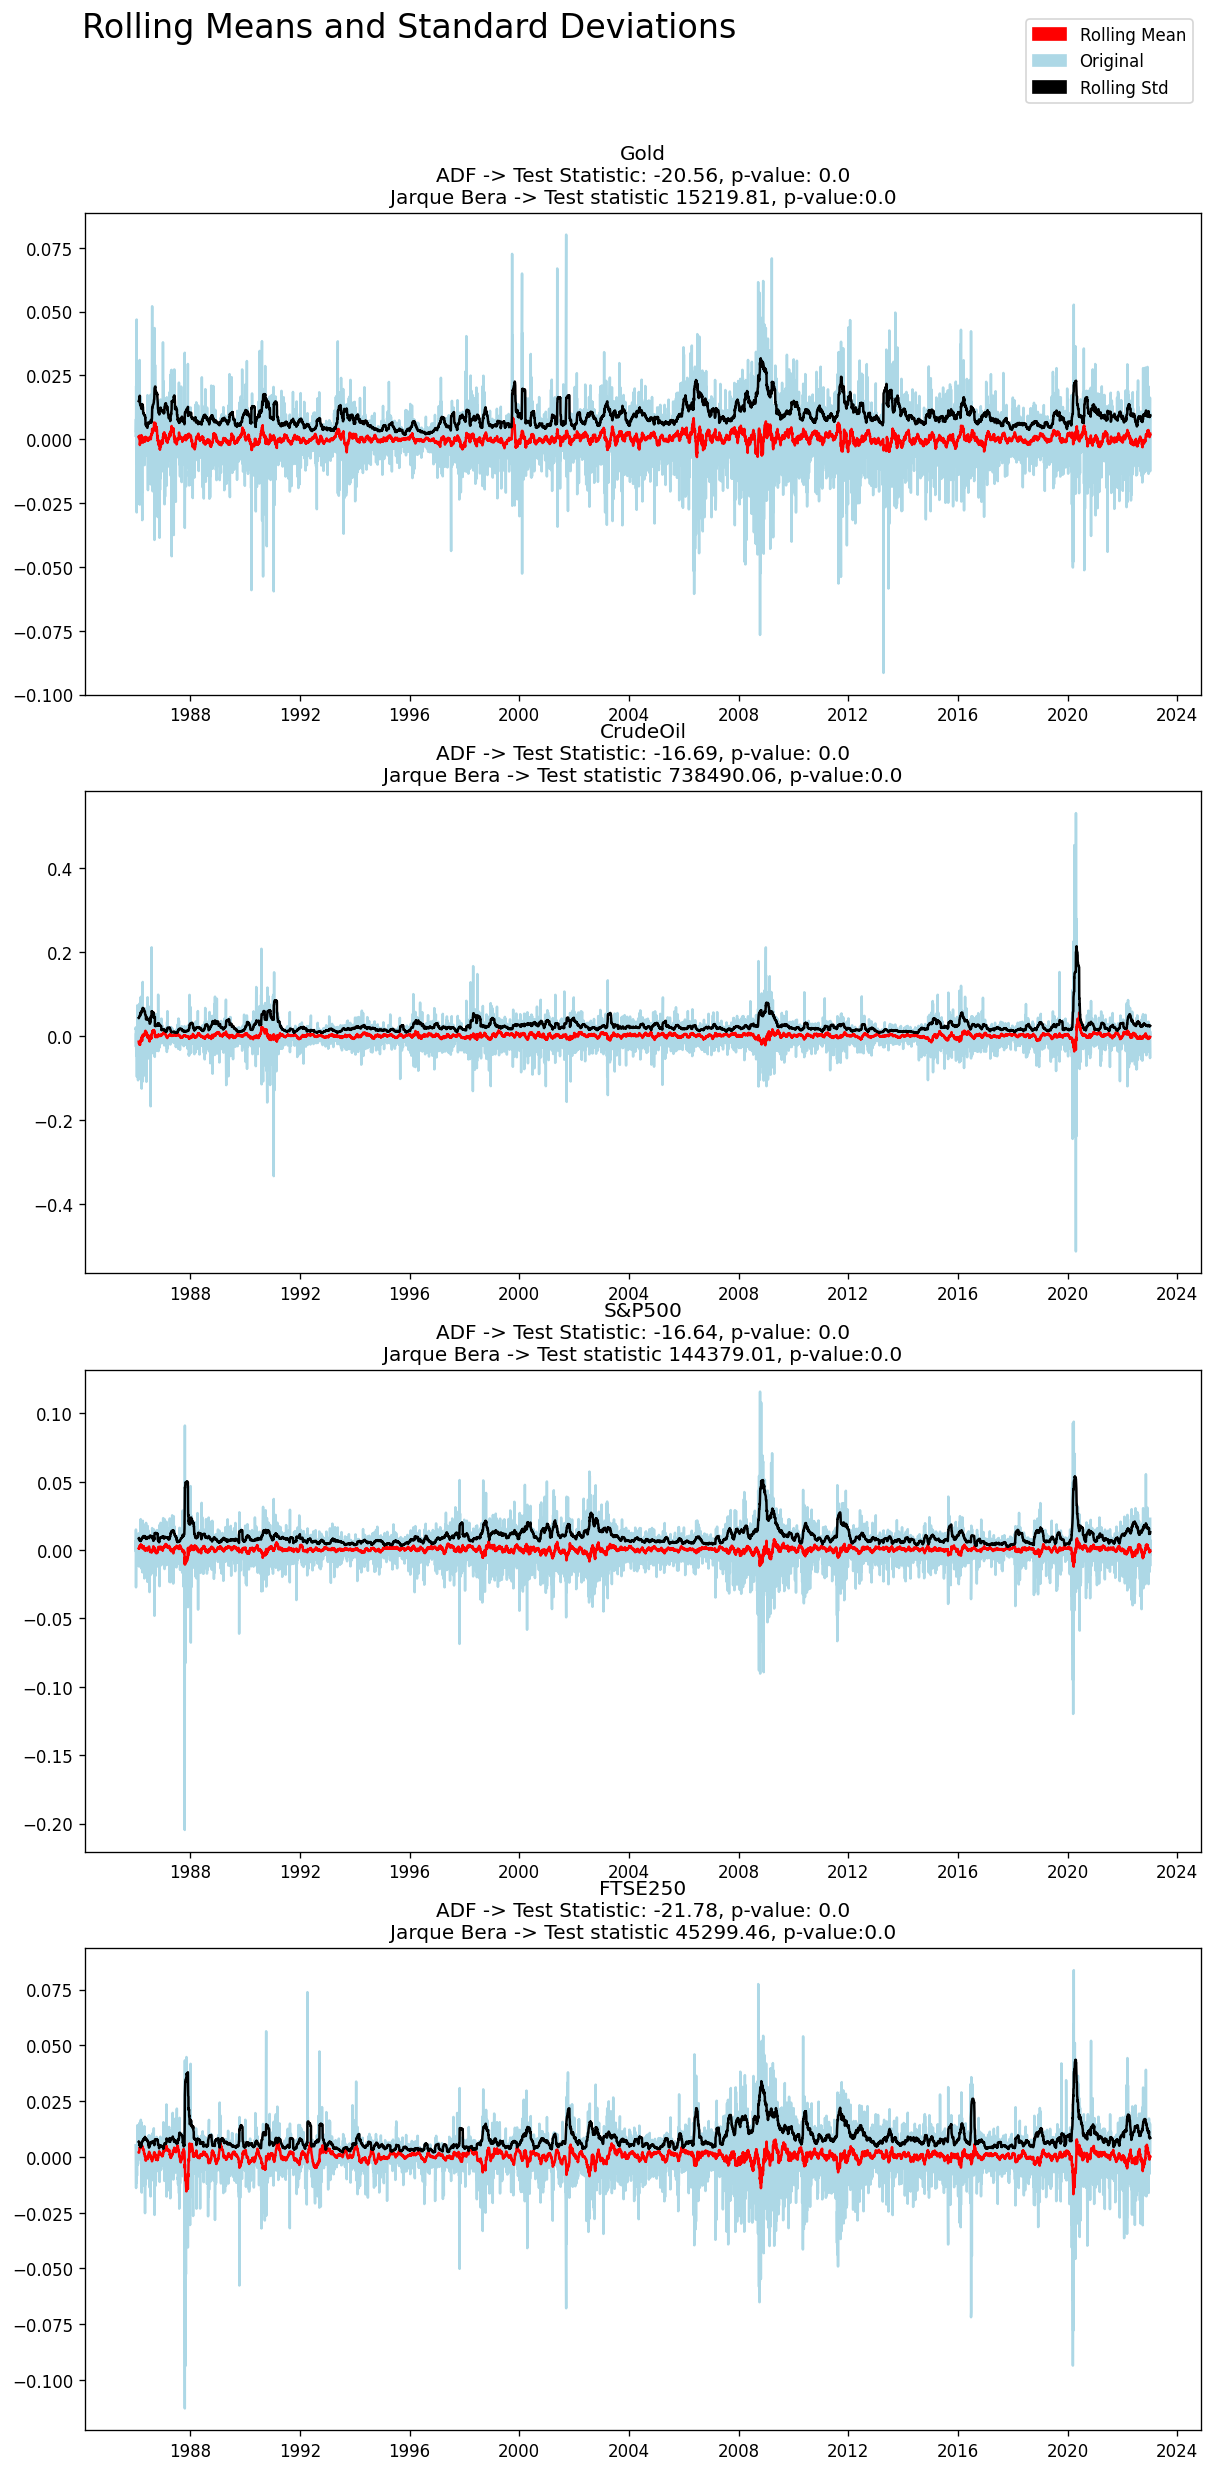

<Figure size 1440x480 with 0 Axes>

In [10]:
plotall(dfr)

<Figure size 1440x480 with 0 Axes>

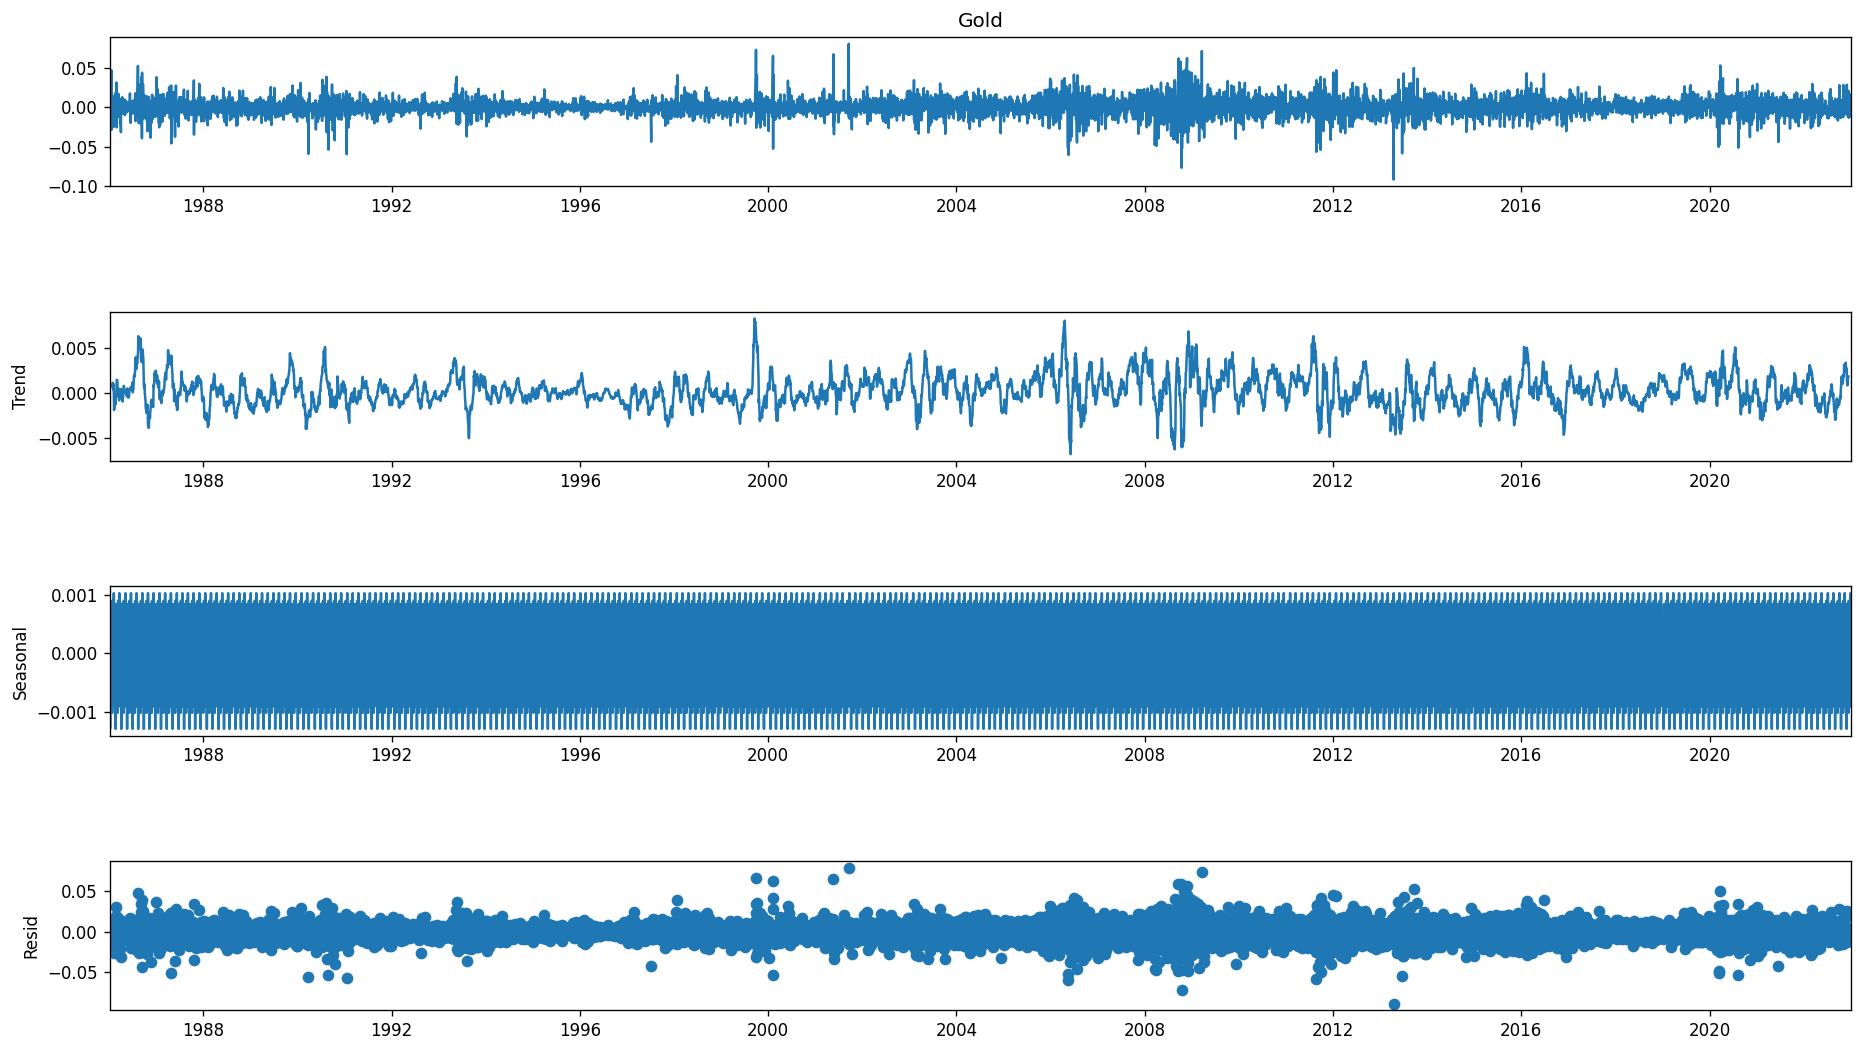

In [11]:
sd_plot  = seasonal_decompose(dfr['Gold'], model='additive', period=30)
fig = plt.figure()
fig = sd_plot.plot()
fig.set_size_inches(16,10)

# 2. Modeling
## 2.1. Time series cross validation - Walk Forward

In [12]:
train1, test1 = dfr.iloc[:-60], dfr.iloc[-60:-40]
train2, test2 = dfr.iloc[:-40], dfr.iloc[-40:-20]
train3, test3 = dfr.iloc[:-20], dfr.iloc[-20:]

y_train_price1, y_test_price1 = df.iloc[:-60].Gold, df.iloc[-60:-40].Gold
y_train_price2, y_test_price2 = df.iloc[:-40].Gold, df.iloc[-40:-20].Gold
y_train_price3, y_test_price3 = df.iloc[:-20].Gold, df.iloc[-20:].Gold
y_trainplt, y_testplt = df.iloc[-60:].Gold, df.iloc[-61:].Gold

Text(0.5, 0, 'Date')

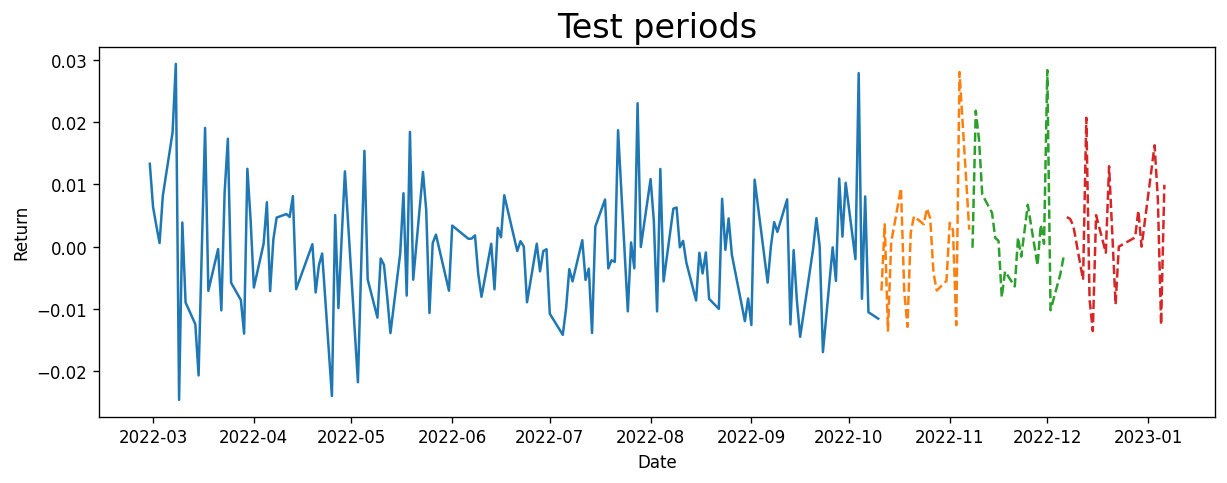

In [13]:
plt.plot(train1.iloc[-150:].index, train1.iloc[-150:].Gold)
plt.plot(test1.index, test1.Gold, linestyle='--')
plt.plot(test2.index, test2.Gold, linestyle='--')
plt.plot(test3.index, test3.Gold, linestyle='--')
plt.title('Test periods', fontsize=20)
plt.ylabel('Return')
plt.xlabel('Date') 

Text(0.5, 1.0, 'Period 3')

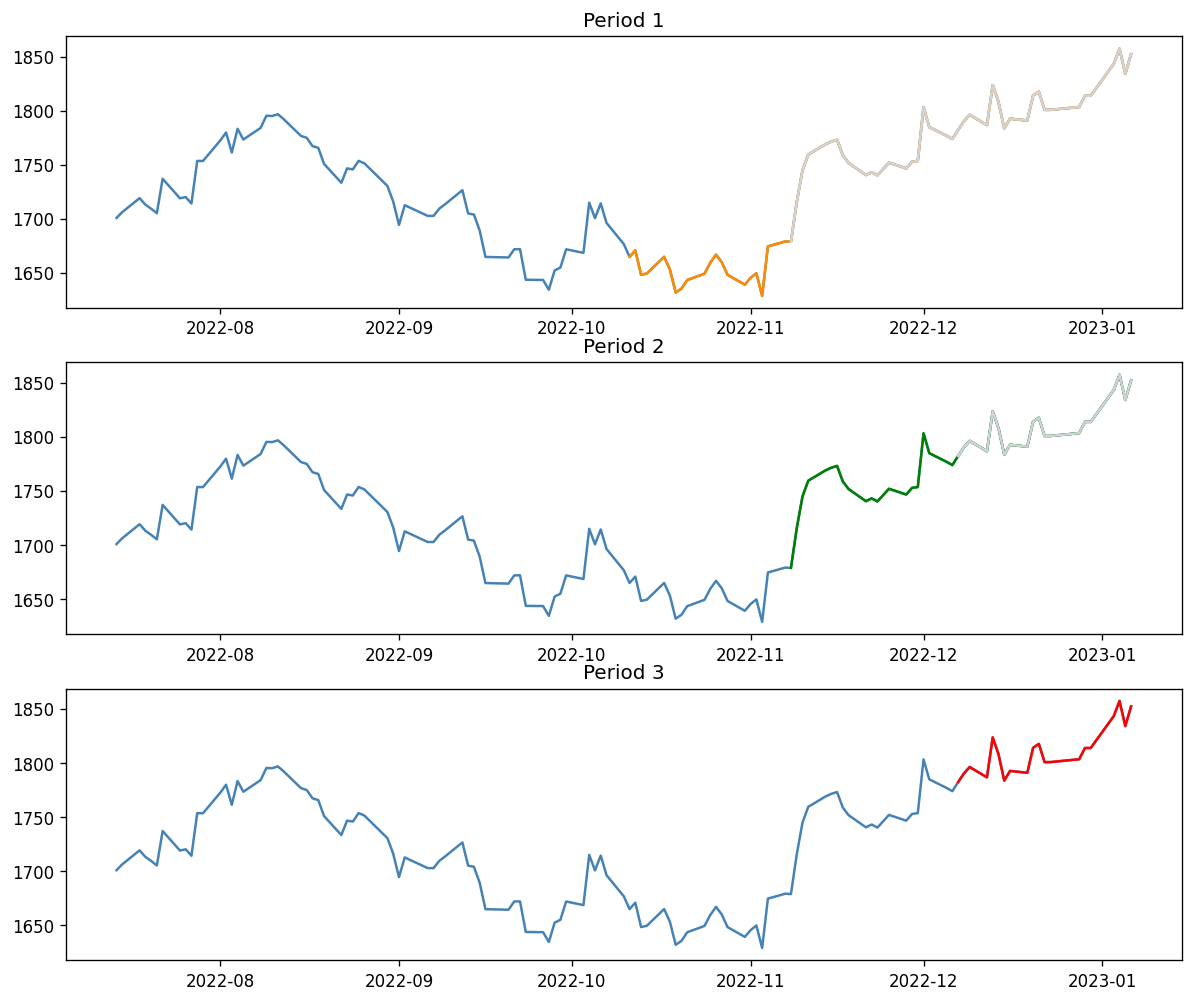

In [14]:
dfplt = df.iloc[-120:]

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,10))

ax1.plot(dfplt.index, dfplt.Gold, color='steelblue')
ax1.plot(dfplt.iloc[-60:].index, dfplt.iloc[-60:].Gold, color='darkorange')
ax1.plot(dfplt.iloc[-40:].index, dfplt.iloc[-40:].Gold, color='lightgray')
ax1.set_title('Period 1')

ax2.plot(dfplt.index, dfplt.Gold, color='steelblue')
ax2.plot(dfplt.iloc[-40:].index, dfplt.iloc[-40:].Gold, color='green')
ax2.plot(dfplt.iloc[-20:].index, dfplt.iloc[-20:].Gold, color='lightgray')
ax2.set_title('Period 2')

ax3.plot(dfplt.index, dfplt.Gold, color='steelblue')
ax3.plot(dfplt.iloc[-20:].index, dfplt.iloc[-20:].Gold, color='red')
ax3.set_title('Period 3')

## 2.2. Univariate ARIMA
### A) Period 1

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-57878.649, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-57879.378, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-57879.403, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-57877.459, Time=0.47 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-57877.558, Time=0.81 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-57875.285, Time=0.99 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-57882.384, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-57881.453, Time=0.88 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-57880.462, Time=1.80 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-57880.583, Time=2.20 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-57882.355, Time=0.55 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-57878.327, Time=0.77 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 10.204 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9088
Model:               SARIMAX(0, 0, 1)   Log Likelihood               28944.192
Date:                Sun, 14 May 2023   AIC                         -57882.384
Time:                        00:18:15   BIC                         -57861.040
Sample:                             0   HQIC                        -57875.125
                               - 9088                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      2.241      0.025     2.9e-05       0.000
ma.L1         -0.0179      0.007     -2.467      0.014      -0.032      -0.004
sigma2         0.0001   7.29e-07    137.449      0.000    9.88e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15365.88
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

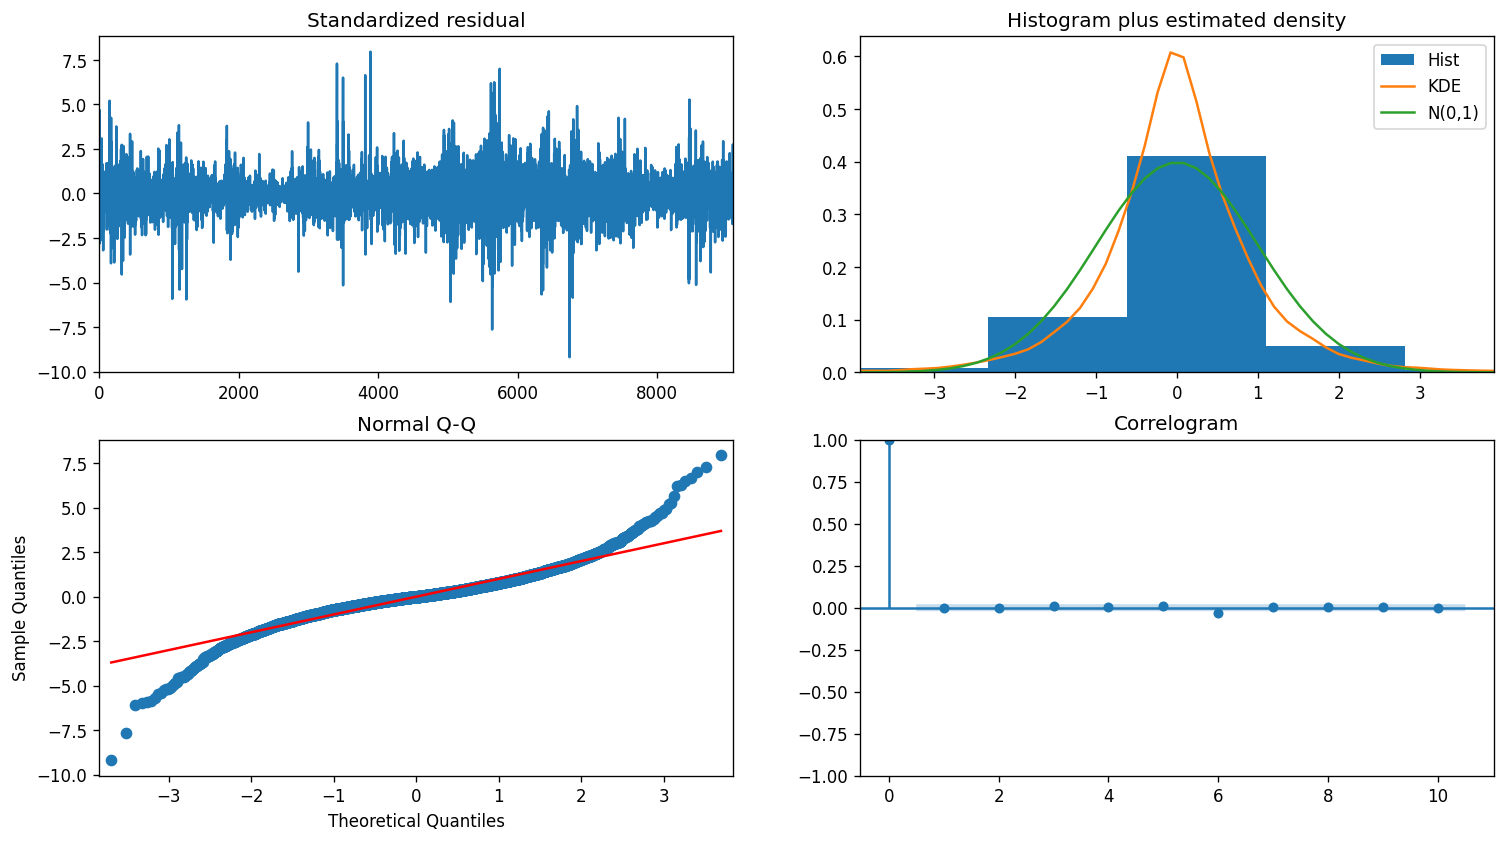

In [15]:
gp_autoARIMAp1 = auto_arima(train1.Gold, 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=5000,
                      scoring='mse',
                      n_jobs=-1)
display(gp_autoARIMAp1.summary())
gp_autoARIMAp1.plot_diagnostics(figsize=(15,8))
plt.show()

Fitting  model sugessted above

In [16]:
gp_autoARIMAp1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9088
Model:               SARIMAX(0, 0, 1)   Log Likelihood               28944.192
Date:                Sun, 14 May 2023   AIC                         -57882.384
Time:                        00:18:16   BIC                         -57861.040
Sample:                             0   HQIC                        -57875.125
                               - 9088                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      2.241      0.025     2.9e-05       0.000
ma.L1         -0.0179      0.007     -2.467      0.014      -0.032      -0.004
sigma2         0.0001   7.29e-07    137.449      0.000    9.88e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15365.88
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
y_hat_gp1 = gp_autoARIMAp1.predict(20)

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [18]:
y_hat_gp1 = pd.DataFrame(y_hat_gp1)
y_hat_gp1.index = test1.index
y_hat_gp1

,0
date,
2022-10-11,0.000446
2022-10-12,0.000231
2022-10-13,0.000231
2022-10-14,0.000231
2022-10-17,0.000231
2022-10-18,0.000231
2022-10-19,0.000231
2022-10-20,0.000231
2022-10-21,0.000231


In [19]:
def get_prices(initial_price:float, return_array):
    '''Helper function to transform returns data into price data'''
    price_arr = np.array([])
    for i in return_array:
        initial_price = initial_price*(i+1)
        price_arr = np.append(price_arr, initial_price)
    
    return price_arr

In [20]:
y_hat_gpprices1 = get_prices(y_train_price1[-1], y_hat_gp1[0])
y_hat_gpprices1 = pd.DataFrame(y_hat_gpprices1)
y_hat_gpprices1.index = y_test_price1.index
y_hat_gpprices1

,0
date,
2022-10-11,1677.297727
2022-10-12,1677.685484
2022-10-13,1678.073330
2022-10-14,1678.461266
2022-10-17,1678.849292
2022-10-18,1679.237407
2022-10-19,1679.625612
2022-10-20,1680.013907
2022-10-21,1680.402292


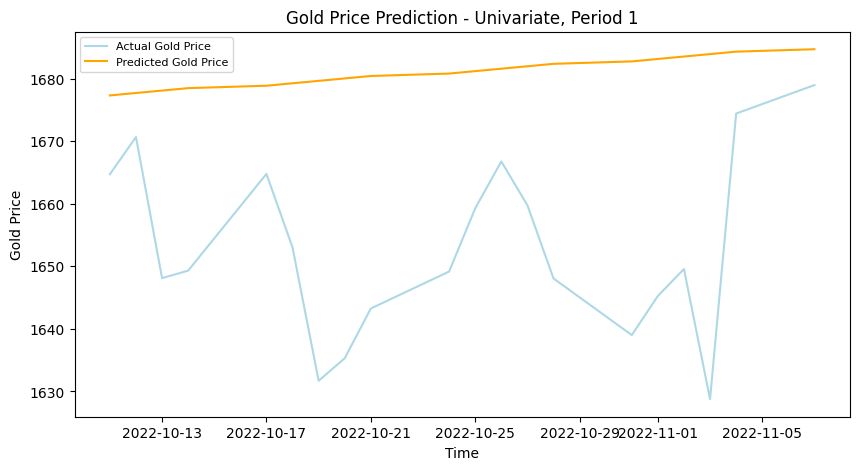

In [21]:
#fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(y_test_price1, color = 'lightblue', label='Actual Gold Price')
plt.plot(y_hat_gpprices1[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - Univariate, Period 1')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [22]:
g_mae = mean_absolute_error(y_test_price1, y_hat_gpprices1)
g_mape = mean_absolute_percentage_error(y_test_price1, y_hat_gpprices1)
g_mse = mean_squared_error(y_test_price1, y_hat_gpprices1)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 28.006530044176305
MAPE: 0.017013419668011186
MSE: 978.2275493967798
RMSE: 31.276629444311606


In [23]:
metric_dict = {'model':[], 'period':[], 'MAE':[], 'MAPE':[], 'MSE':[], 'RMSE':[]}

metric_dict['model'].append('univariate')
metric_dict['period'].append(1)
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

### B) Period 2

Performing stepwise search to minimize aic


c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-58008.897, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-58009.688, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-58009.715, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-58007.776, Time=0.48 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-58007.888, Time=0.76 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-58005.637, Time=1.97 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-58012.698, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-58011.702, Time=0.97 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-58010.783, Time=1.69 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-58010.916, Time=1.73 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-58012.667, Time=0.56 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-58008.686, Time=3.88 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 13.710 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9108
Model:               SARIMAX(0, 0, 1)   Log Likelihood               29009.349
Date:                Sun, 14 May 2023   AIC                         -58012.698
Time:                        00:18:30   BIC                         -57991.347
Sample:                             0   HQIC                        -58005.437
                               - 9108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      2.242      0.025     2.9e-05       0.000
ma.L1         -0.0181      0.007     -2.493      0.013      -0.032      -0.004
sigma2         0.0001   7.29e-07    137.551      0.000    9.88e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15366.50
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

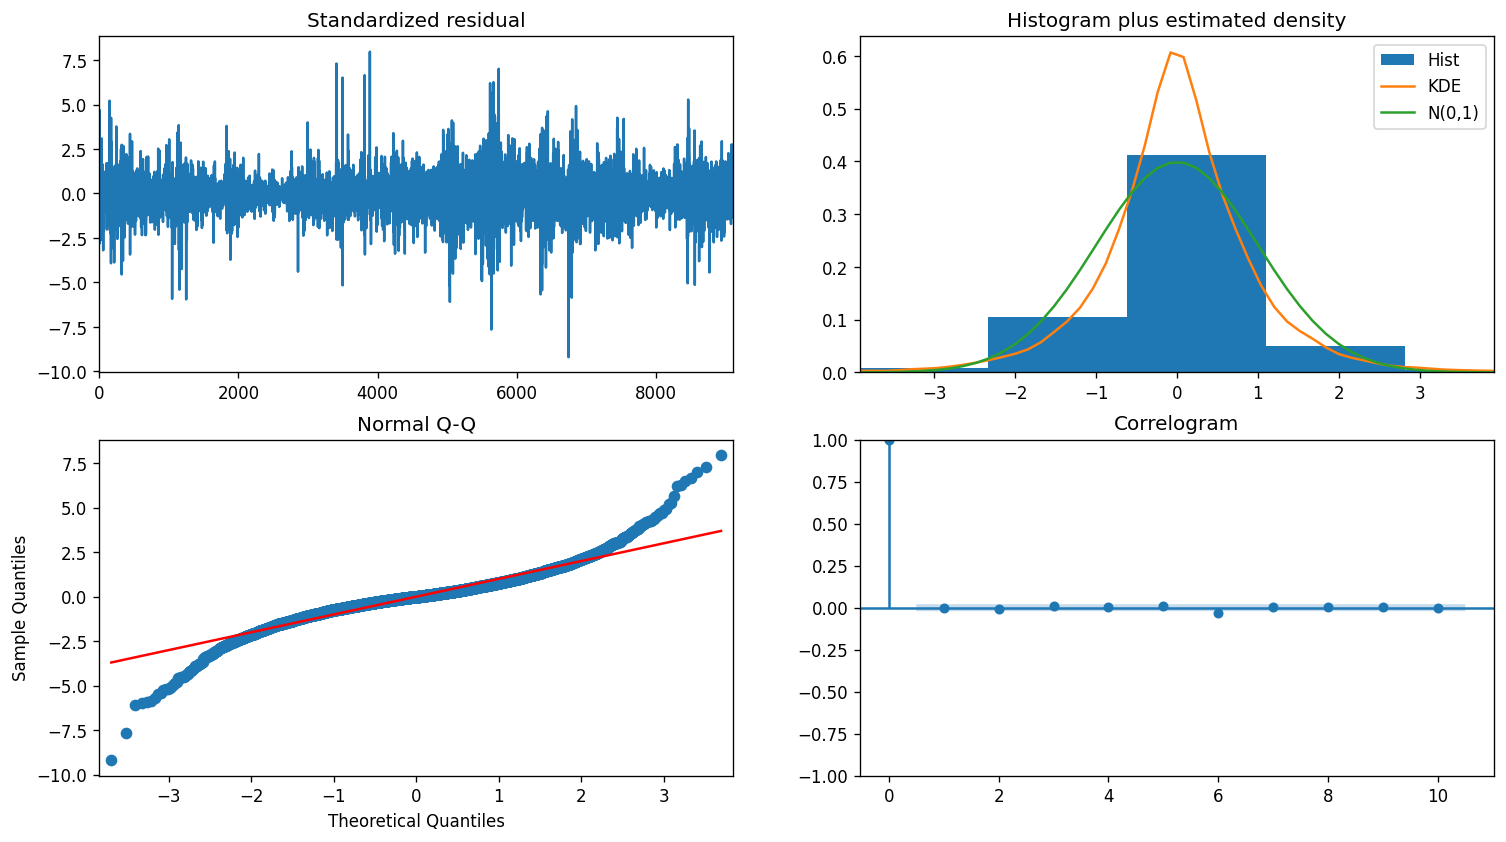

In [24]:
gp_autoARIMAp2 = auto_arima(train2.Gold, 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=5000,
                      scoring='mse',
                      n_jobs=-1)
display(gp_autoARIMAp2.summary())
gp_autoARIMAp2.plot_diagnostics(figsize=(15,8))
plt.show()

In [25]:
y_hat_gp2 = gp_autoARIMAp2.predict(20)

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [26]:
y_hat_gp2 = pd.DataFrame(y_hat_gp2)
y_hat_gp2.index = test2.index
y_hat_gp2

,0
date,
2022-11-08,0.000177
2022-11-09,0.000231
2022-11-10,0.000231
2022-11-11,0.000231
2022-11-14,0.000231
2022-11-15,0.000231
2022-11-16,0.000231
2022-11-17,0.000231
2022-11-18,0.000231


In [27]:
y_hat_gpprices2 = get_prices(y_train_price2[-1], y_hat_gp1[0])
y_hat_gpprices2 = pd.DataFrame(y_hat_gpprices2)
y_hat_gpprices2.index = y_test_price2.index
y_hat_gpprices2

,0
date,
2022-11-08,1679.698798
2022-11-09,1680.087109
2022-11-10,1680.475511
2022-11-11,1680.864002
2022-11-14,1681.252583
2022-11-15,1681.641254
2022-11-16,1682.030015
2022-11-17,1682.418866
2022-11-18,1682.807806


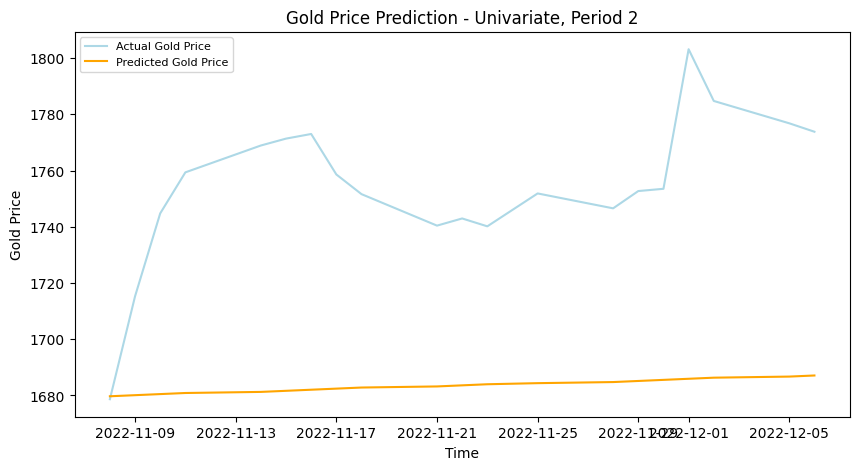

In [28]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(y_test_price2, color = 'lightblue', label='Actual Gold Price')
plt.plot(y_hat_gpprices2[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - Univariate, Period 2')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [29]:
g_mae = mean_absolute_error(y_test_price2, y_hat_gpprices2)
g_mape = mean_absolute_percentage_error(y_test_price2, y_hat_gpprices2)
g_mse = mean_squared_error(y_test_price2, y_hat_gpprices2)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 71.1144987862565
MAPE: 0.04034229369261161
MSE: 5632.325487589453
RMSE: 75.04882069419514


In [30]:
metric_dict['model'].append('univariate')
metric_dict['period'].append(2)
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

### C) Period 3

Performing stepwise search to minimize aic


c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-58136.382, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-58137.048, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-58137.071, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-58135.113, Time=0.57 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-58135.209, Time=0.77 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-58132.908, Time=1.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-58140.309, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-58139.436, Time=0.86 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-58138.375, Time=1.73 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-58138.490, Time=2.78 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-58140.281, Time=0.76 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-58136.201, Time=2.43 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 12.717 seconds
                               SARIMAX Results                                
Dep. Variable:             

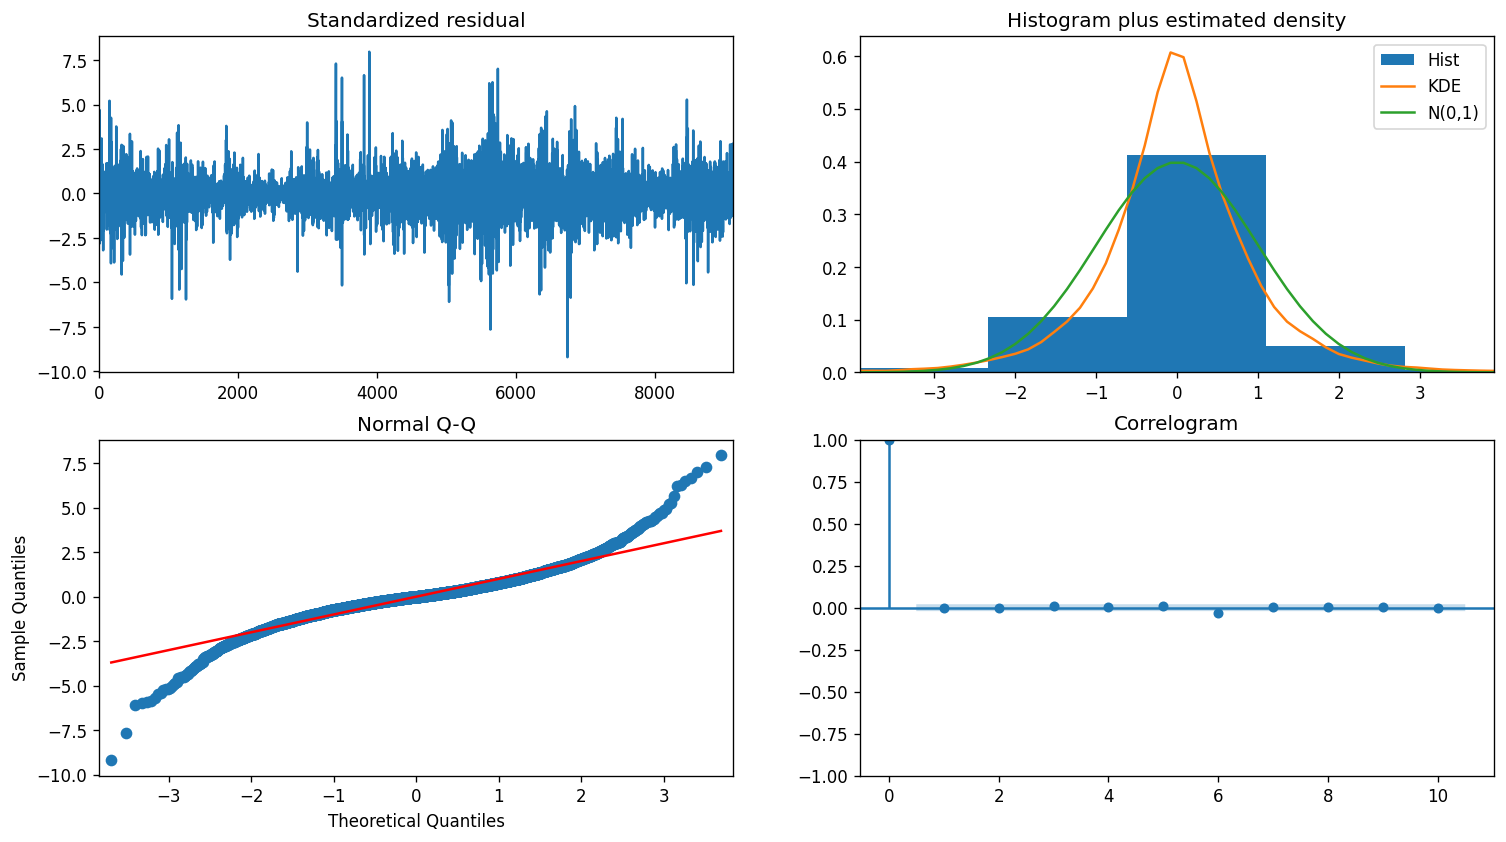

In [31]:
gp_autoARIMAp3 = auto_arima(train3.Gold, 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=5000,
                      scoring='mse',
                      n_jobs=-1)
print(gp_autoARIMAp3.summary())
gp_autoARIMAp3.plot_diagnostics(figsize=(15,8))
plt.show()

In [32]:
y_hat_gp3 = gp_autoARIMAp3.predict(20)

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [33]:
y_hat_gp3 = pd.DataFrame(y_hat_gp3)
y_hat_gp3.index = test3.index
y_hat_gp3

,0
date,
2022-12-07,0.000272
2022-12-08,0.000237
2022-12-09,0.000237
2022-12-12,0.000237
2022-12-13,0.000237
2022-12-14,0.000237
2022-12-15,0.000237
2022-12-16,0.000237
2022-12-19,0.000237


In [34]:
y_hat_gpprices3 = get_prices(y_train_price3[-1], y_hat_gp3[0])
y_hat_gpprices3 = pd.DataFrame(y_hat_gpprices3)
y_hat_gpprices3.index = y_test_price3.index
y_hat_gpprices3

,0
date,
2022-12-07,1774.282802
2022-12-08,1774.702526
2022-12-09,1775.122350
2022-12-12,1775.542272
2022-12-13,1775.962294
2022-12-14,1776.382415
2022-12-15,1776.802636
2022-12-16,1777.222956
2022-12-19,1777.643376


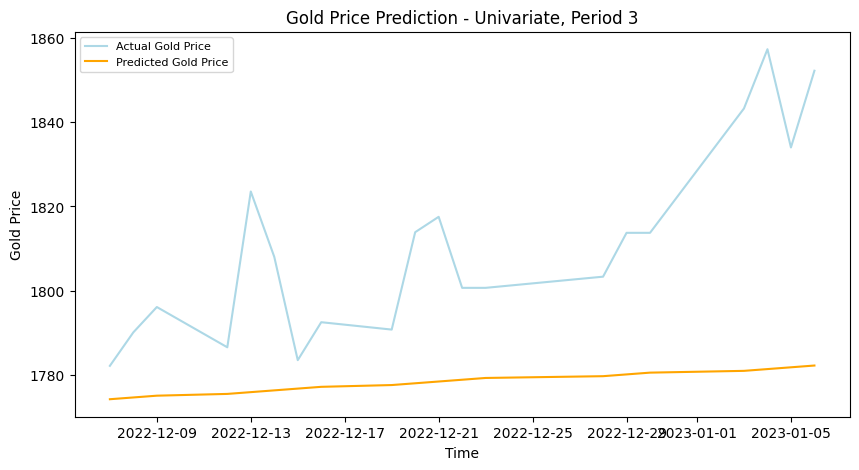

In [35]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(y_test_price3, color = 'lightblue', label='Actual Gold Price')
plt.plot(y_hat_gpprices3[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - Univariate, Period 3')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [36]:
g_mae = mean_absolute_error(y_test_price3, y_hat_gpprices3)
g_mape = mean_absolute_percentage_error(y_test_price3, y_hat_gpprices3)
g_mse = mean_squared_error(y_test_price3, y_hat_gpprices3)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 31.926654533288023
MAPE: 0.017508507110765924
MSE: 1417.603342779859
RMSE: 37.65107359398745


In [37]:
metric_dict['model'].append('univariate')
metric_dict['period'].append(3)
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

###  All Periods plotted

In [38]:
pd.DataFrame(metric_dict)

,model,period,MAE,MAPE,MSE,RMSE
0,univariate,1,28.006530,0.017013,978.227549,31.276629
1,univariate,2,71.114499,0.040342,5632.325488,75.048821
2,univariate,3,31.926655,0.017509,1417.603343,37.651074


Text(0.5, 0, 'Date')

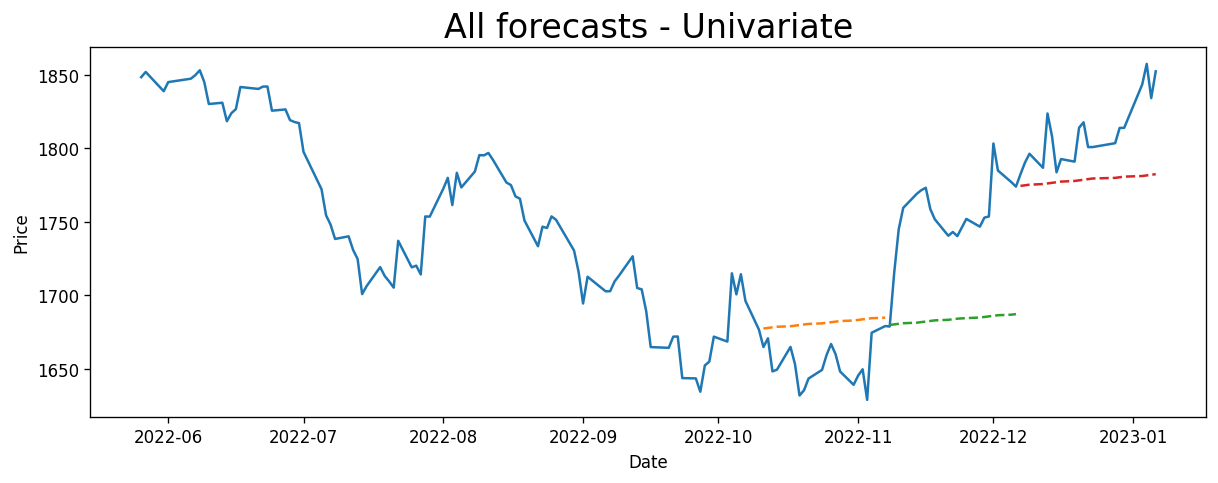

In [39]:
plt.plot(df.iloc[-150:].index, df.iloc[-150:].Gold)
plt.plot(y_hat_gpprices1.index, y_hat_gpprices1[0], linestyle='--')
plt.plot(y_hat_gpprices2.index, y_hat_gpprices2[0], linestyle='--')
plt.plot(y_hat_gpprices3.index, y_hat_gpprices3[0], linestyle='--')
plt.title('All forecasts - Univariate', fontsize=20)
plt.ylabel('Price')
plt.xlabel('Date')

## 2.3. Multivariate ARIMA
### A) Period 1

In [40]:
train1

,Gold,CrudeOil,S&P500,FTSE250
date,,,,
1986-01-03,0.001379,0.017214,0.006155,0.005186
1986-01-06,0.003826,0.020385,-0.001091,0.004457
1986-01-07,0.006098,-0.025631,0.014954,-0.006807
1986-01-08,0.007879,0.000774,-0.027268,-0.008746
1986-01-09,0.002706,0.006185,-0.008944,-0.013941
...,...,...,...,...
2022-10-04,0.027841,0.033551,0.030584,0.031083
2022-10-05,-0.008368,0.015540,-0.002018,-0.014573
2022-10-06,0.008056,0.007708,-0.010245,0.003998


c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-57996.421, Time=3.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-58000.737, Time=0.86 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-58000.757, Time=1.99 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-57998.760, Time=2.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-57998.759, Time=3.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-57996.590, Time=1.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-58003.480, Time=1.96 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-57998.893, Time=1.84 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-58001.480, Time=5.42 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-58001.493, Time=2.71 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-58003.453, Time=1.57 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-57999.272, Time=6.24 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 32.009 seconds
                               SARIMAX Results                 

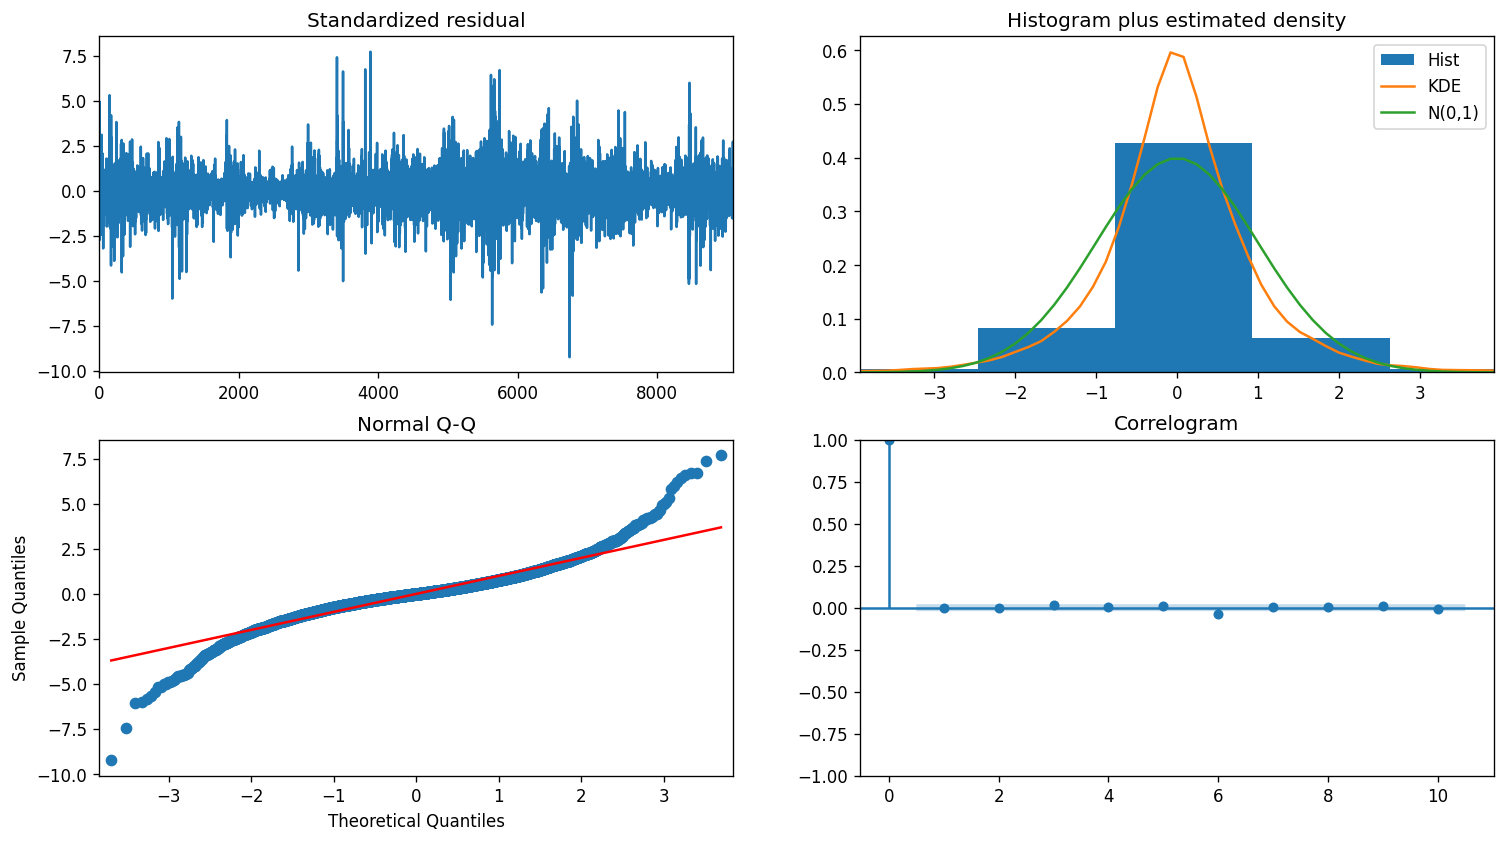

In [41]:
mv_autoARIMAp1 = auto_arima(y=train1.Gold, X=train1.drop('Gold', axis=1), 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=5000,
                      scoring='mse',
                      n_jobs=-1)
print(mv_autoARIMAp1.summary())
mv_autoARIMAp1.plot_diagnostics(figsize=(15,8))
plt.show()

In [42]:
y_hat_mv1 = mv_autoARIMAp1.predict(20, test1.drop('Gold', axis=1))

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [43]:
y_hat_mv1 = pd.DataFrame(y_hat_mv1)
y_hat_mv1.index = test1.index
y_hat_mv1

,0
date,
2022-10-11,-0.000140
2022-10-12,-0.000674
2022-10-13,0.000187
2022-10-14,-0.000335
2022-10-17,-0.000593
2022-10-18,-0.001469
2022-10-19,0.001621
2022-10-20,0.000627
2022-10-21,-0.001074


In [44]:
y_hat_mvprices1 = get_prices(y_train_price1[-1], y_hat_mv1[0])
y_hat_mvprices1 = pd.DataFrame(y_hat_mvprices1)
y_hat_mvprices1.index = y_test_price1.index
y_hat_mvprices1

,0
date,
2022-10-11,1676.315080
2022-10-12,1675.185574
2022-10-13,1675.499572
2022-10-14,1674.938792
2022-10-17,1673.945376
2022-10-18,1671.485628
2022-10-19,1674.195516
2022-10-20,1675.245996
2022-10-21,1673.446556


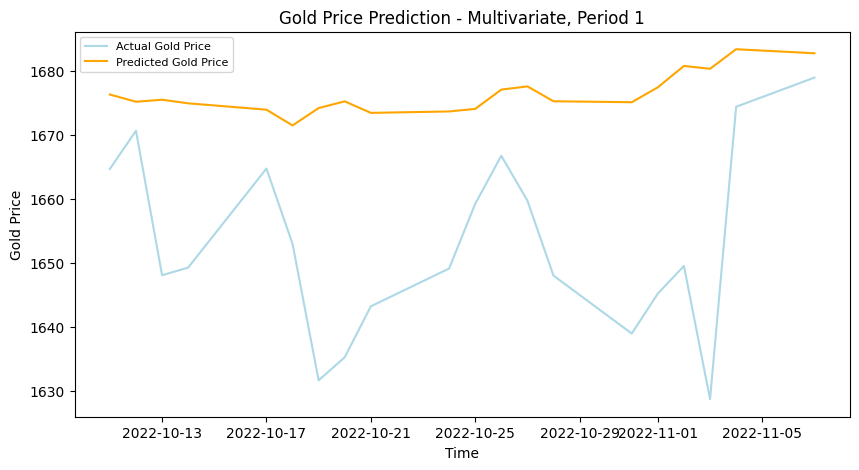

In [45]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(y_test_price1, color = 'lightblue', label='Actual Gold Price')
plt.plot(y_hat_mvprices1[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - Multivariate, Period 1')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [46]:
g_mae = mean_absolute_error(y_test_price1, y_hat_mvprices1)
g_mape = mean_absolute_percentage_error(y_test_price1, y_hat_mvprices1)
g_mse = mean_squared_error(y_test_price1, y_hat_mvprices1)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 23.405208314169602
MAPE: 0.0142244419405056
MSE: 717.9693677287274
RMSE: 26.79495041474657


In [47]:
metric_dict['model'].append('multivariate')
metric_dict['period'].append(1)
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

### B) Period 2

Performing stepwise search to minimize aic

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-58127.723, Time=3.41 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-58132.151, Time=0.71 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-58132.176, Time=1.81 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-58130.182, Time=2.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-58130.185, Time=3.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-58127.985, Time=1.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-58134.887, Time=2.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-58130.184, Time=2.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-58132.892, Time=2.70 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-58132.910, Time=2.34 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-58134.855, Time=0.95 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-58130.669, Time=5.11 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 27.607 seconds
                               SARIMAX Results                                
Dep. Variable:            

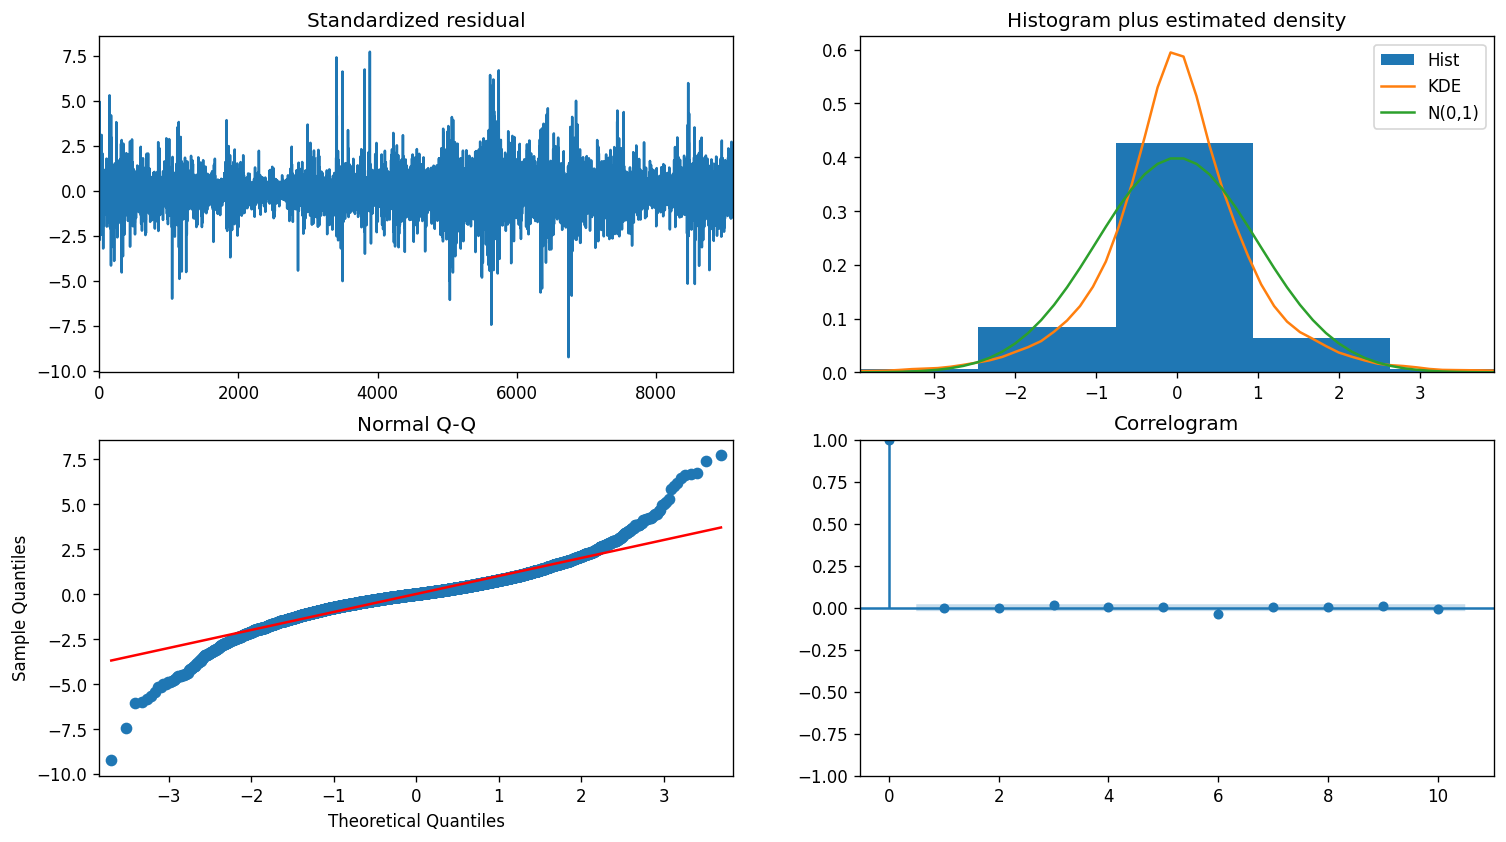

In [48]:
mv_autoARIMAp2 = auto_arima(y=train2.Gold, X=train2.drop('Gold', axis=1), 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=5000,
                      scoring='mse',
                      n_jobs=-1)
print(mv_autoARIMAp2.summary())
mv_autoARIMAp2.plot_diagnostics(figsize=(15,8))
plt.show()

In [49]:
y_hat_mv2 = mv_autoARIMAp2.predict(20, test2.drop('Gold', axis=1))

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [50]:
y_hat_mv2 = pd.DataFrame(y_hat_mv2)
y_hat_mv2.index = test2.index
y_hat_mv2

,0
date,
2022-11-08,-0.001326
2022-11-09,-0.000343
2022-11-10,-0.001191
2022-11-11,0.001205
2022-11-14,-0.000898
2022-11-15,0.000259
2022-11-16,-0.000224
2022-11-17,-0.001486
2022-11-18,-0.000666


In [51]:
y_hat_mvprices2 = get_prices(y_train_price2[-1], y_hat_mv2[0])
y_hat_mvprices2 = pd.DataFrame(y_hat_mvprices2)
y_hat_mvprices2.index = y_test_price2.index
y_hat_mvprices2

,0
date,
2022-11-08,1676.724172
2022-11-09,1676.148219
2022-11-10,1674.151920
2022-11-11,1676.168667
2022-11-14,1674.662837
2022-11-15,1675.097039
2022-11-16,1674.721992
2022-11-17,1672.233282
2022-11-18,1671.119967


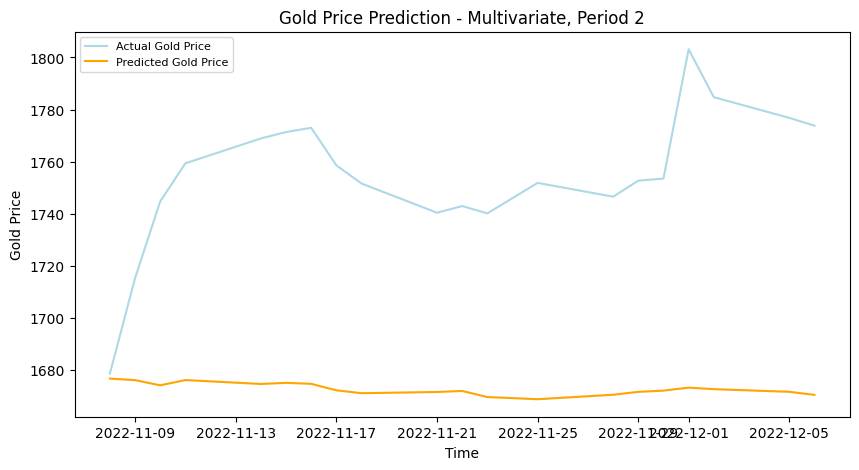

In [52]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(y_test_price2, color = 'lightblue', label='Actual Gold Price')
plt.plot(y_hat_mvprices2[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - Multivariate, Period 2')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [53]:
g_mae = mean_absolute_error(y_test_price2, y_hat_mvprices2)
g_mape = mean_absolute_percentage_error(y_test_price2, y_hat_mvprices2)
g_mse = mean_squared_error(y_test_price2, y_hat_mvprices2)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 81.63000520527842
MAPE: 0.046318989103190496
MSE: 7347.161299199195
RMSE: 85.71558375930945


In [54]:
metric_dict['model'].append('multivariate')
metric_dict['period'].append(2)
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

### C) Period 3

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-58255.126, Time=3.61 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-58259.337, Time=0.65 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-58259.354, Time=2.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-58257.356, Time=2.34 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-58257.355, Time=3.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-58255.189, Time=0.99 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-58262.343, Time=2.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-58257.855, Time=2.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-58260.342, Time=2.31 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-58260.354, Time=2.59 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-58262.318, Time=0.98 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-58258.113, Time=2.59 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 25.708 seconds
                               SARIMAX Results                 

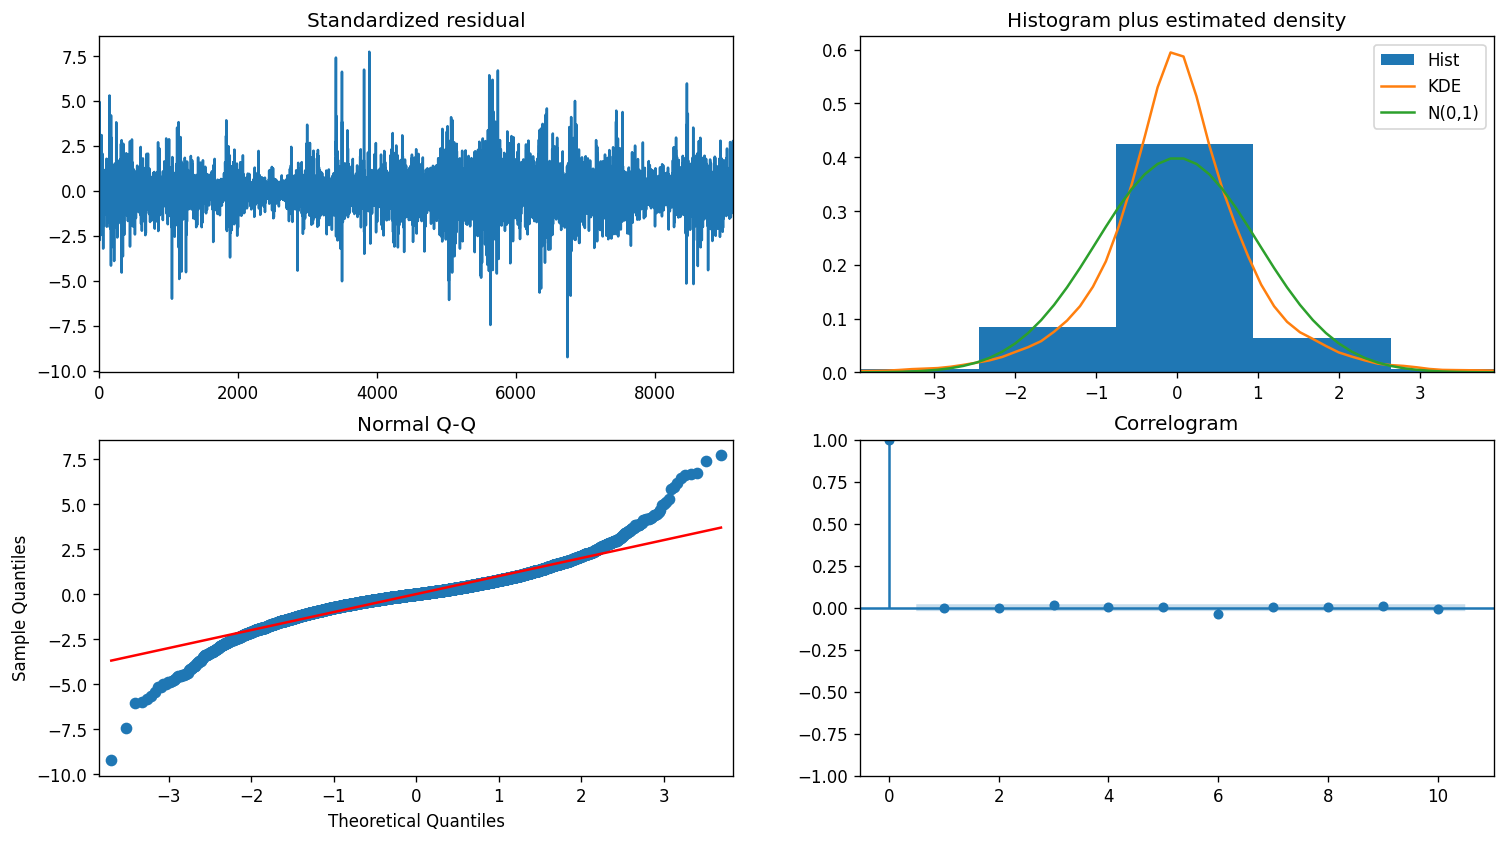

In [55]:
mv_autoARIMAp3 = auto_arima(y=train3.Gold, X=train3.drop('Gold', axis=1), 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=5000,
                      scoring='mse',
                      n_jobs=-1)
print(mv_autoARIMAp3.summary())
mv_autoARIMAp3.plot_diagnostics(figsize=(15,8))
plt.show()

In [56]:
y_hat_mv3 = mv_autoARIMAp3.predict(20, test3.drop('Gold', axis=1))

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [57]:
y_hat_mv3 = pd.DataFrame(y_hat_mv3)
y_hat_mv3.index = test3.index
y_hat_mv3

,0
date,
2022-12-07,-0.001006
2022-12-08,-0.000486
2022-12-09,0.000436
2022-12-12,0.000678
2022-12-13,0.001473
2022-12-14,0.001334
2022-12-15,0.000466
2022-12-16,-0.000427
2022-12-19,0.001084


In [58]:
y_hat_mvprices3 = get_prices(y_train_price3[-1], y_hat_mv3[0])
y_hat_mvprices3 = pd.DataFrame(y_hat_mvprices3)
y_hat_mvprices3.index = y_test_price3.index
y_hat_mvprices3

,0
date,
2022-12-07,1772.015986
2022-12-08,1771.154663
2022-12-09,1771.927228
2022-12-12,1773.129394
2022-12-13,1775.740937
2022-12-14,1778.110443
2022-12-15,1778.939576
2022-12-16,1778.179273
2022-12-19,1780.107227


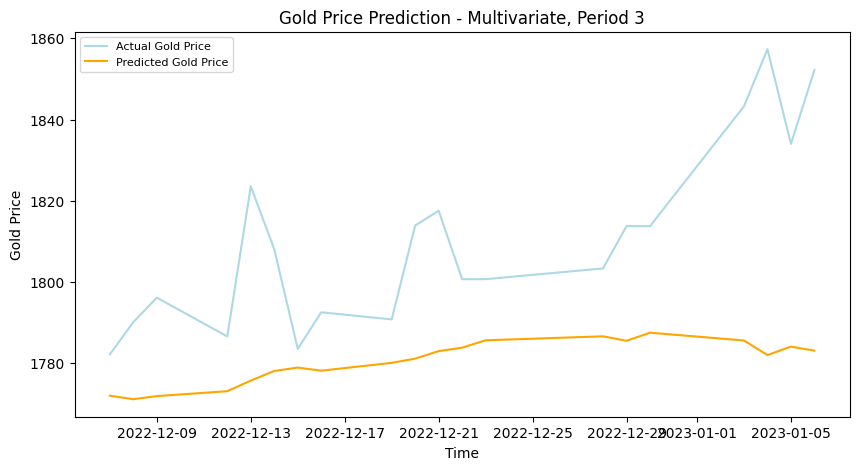

In [59]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(y_test_price3, color = 'lightblue', label='Actual Gold Price')
plt.plot(y_hat_mvprices3[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - Multivariate, Period 3')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [60]:
g_mae = mean_absolute_error(y_test_price3, y_hat_mvprices3)
g_mape = mean_absolute_percentage_error(y_test_price3, y_hat_mvprices3)
g_mse = mean_squared_error(y_test_price3, y_hat_mvprices3)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 29.82811439607724
MAPE: 0.01635389257781284
MSE: 1277.4743417948957
RMSE: 35.74177306450949


In [61]:
metric_dict['model'].append('multivariate')
metric_dict['period'].append(3)
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

### All  periods

In [62]:
pd.DataFrame(metric_dict)

,model,period,MAE,MAPE,MSE,RMSE
0,univariate,1,28.006530,0.017013,978.227549,31.276629
1,univariate,2,71.114499,0.040342,5632.325488,75.048821
2,univariate,3,31.926655,0.017509,1417.603343,37.651074
3,multivariate,1,23.405208,0.014224,717.969368,26.794950
4,multivariate,2,81.630005,0.046319,7347.161299,85.715584
5,multivariate,3,29.828114,0.016354,1277.474342,35.741773


Text(0.5, 0, 'Date')

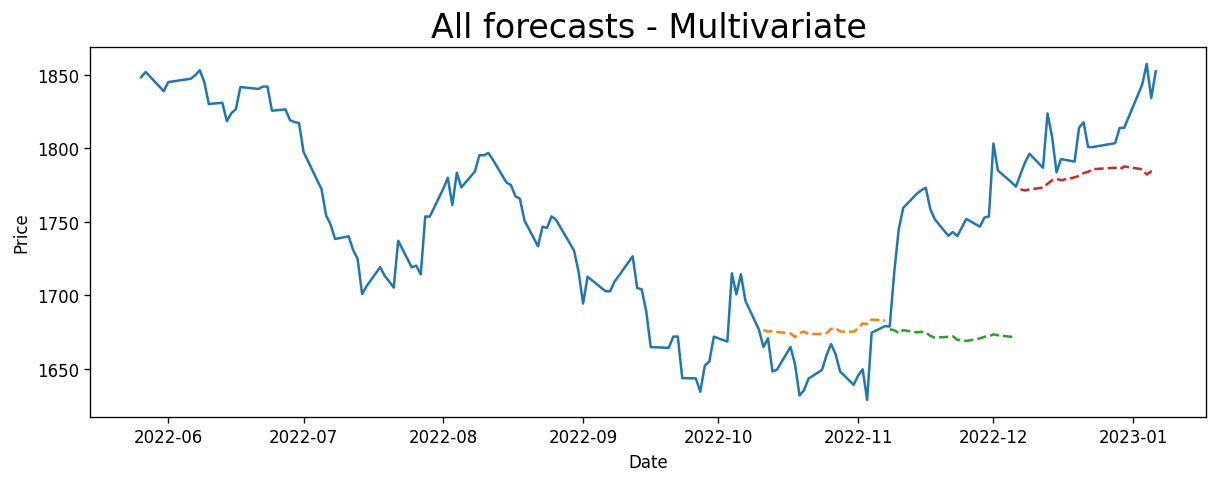

In [63]:
plt.plot(df.iloc[-150:].index, df.iloc[-150:].Gold)
plt.plot(y_hat_mvprices1.index, y_hat_mvprices1[0], linestyle='--')
plt.plot(y_hat_mvprices2.index, y_hat_mvprices2[0], linestyle='--')
plt.plot(y_hat_mvprices3.index, y_hat_mvprices3[0], linestyle='--')
plt.title('All forecasts - Multivariate', fontsize=20)
plt.ylabel('Price')
plt.xlabel('Date')

---
# ARIMA with less data
Since econometric approaches are more suitable than deep learning with lower amounts of data, let's try reducing the dataset size to most recent year and see if the results maybe improve.

In [64]:
df_log.tail()

NameError: name 'df_log' is not defined

In [ ]:
df_log_cut = df_log[df_log.index>'2022-01-05']
df_log_cut

,Gold,CrudeOil,S&P500,FTSE250
date,,,,
2022-01-06,7.489608,4.375380,8.454477,10.061214
2022-01-07,7.491422,4.369448,8.450419,10.058491
2022-01-10,7.492315,4.358118,8.448976,10.043328
2022-01-11,7.499313,4.396546,8.458095,10.044474
2022-01-12,7.507361,4.412919,8.460909,10.045298
...,...,...,...,...
2022-12-30,7.503152,4.384025,8.253097,9.844427
2023-01-03,7.519286,4.342116,8.249089,9.859240
2023-01-04,7.526879,4.287991,8.256600,9.872568


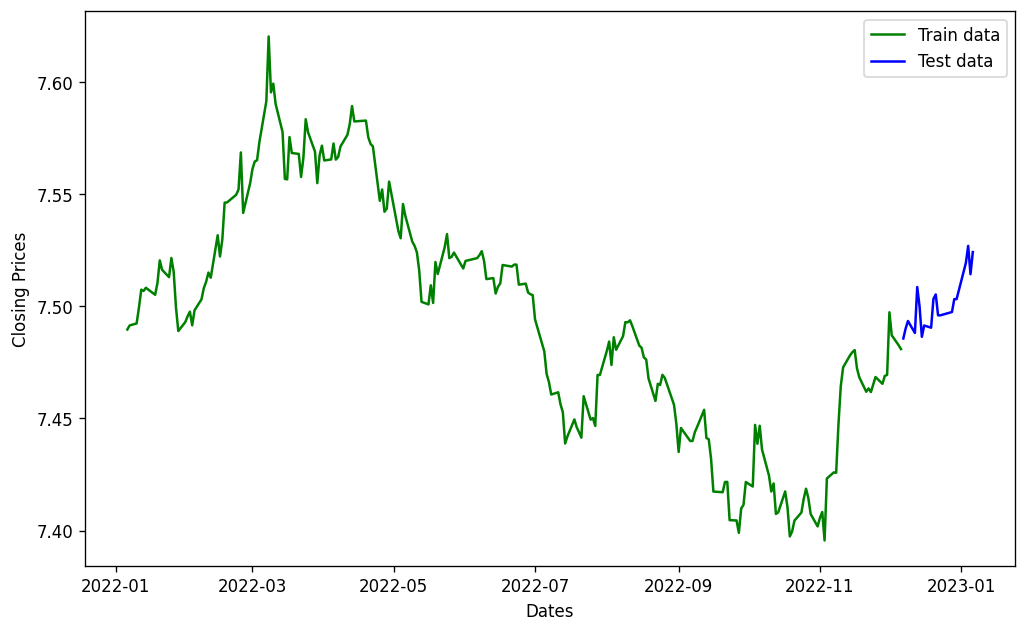

In [ ]:
y = df_log_cut['Gold']
X = df_log_cut.drop('Gold', axis=1)

X_train, X_test, y_train, y_test=  X[:-20], X[-20:], y[:-20], y[-20:]
plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(y_train, 'green', label='Train data')
plt.plot(y_test, 'blue', label='Test data')
plt.legend()

## Only Gold price

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1454.443, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1453.533, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1453.424, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1456.439, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1451.660, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.239 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 729.220
Date:                Thu, 13 Apr 2023   AIC                          -1456.439
Time:                        22:12:55   BIC                          -1453.028
Sample:                             0   HQIC                         -1455.062
                                - 225                                  

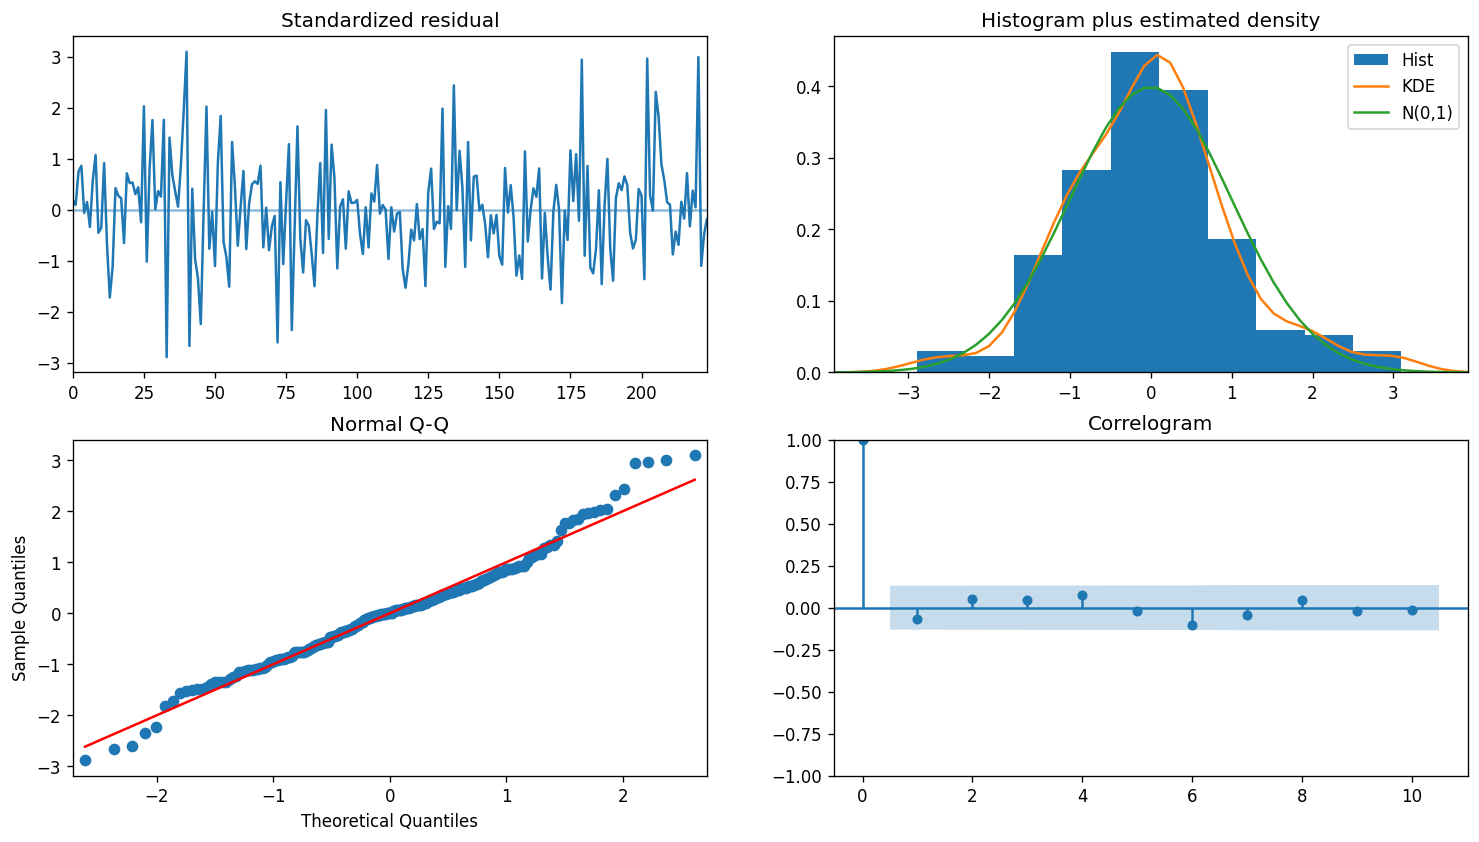

In [ ]:
gpcut_autoARIMA = auto_arima(y_train, 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=500,
                      scoring='mse',
                      n_jobs=-1)
print(gpcut_autoARIMA.summary())
gpcut_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
gpcut_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 729.220
Date:                Thu, 13 Apr 2023   AIC                          -1456.439
Time:                        22:12:56   BIC                          -1453.028
Sample:                             0   HQIC                         -1455.062
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.698e-05   6.78e-06     12.820      0.000    7.37e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):                11.80
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.31
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
y_hat_gpc = gpcut_autoARIMA.predict(20)

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
y_hat_gpc = pd.DataFrame(y_hat_gpc)
y_hat_gpc.index = y_test.index
y_hat_gpc

,0
date,
2022-12-07,7.480879
2022-12-08,7.480879
2022-12-09,7.480879
2022-12-12,7.480879
2022-12-13,7.480879
2022-12-14,7.480879
2022-12-15,7.480879
2022-12-16,7.480879
2022-12-19,7.480879


In [ ]:
inv_ytr = np.exp(y_train)
inv_yt = np.exp(y_test)
inv_yhgpc = np.exp(y_hat_gpc)

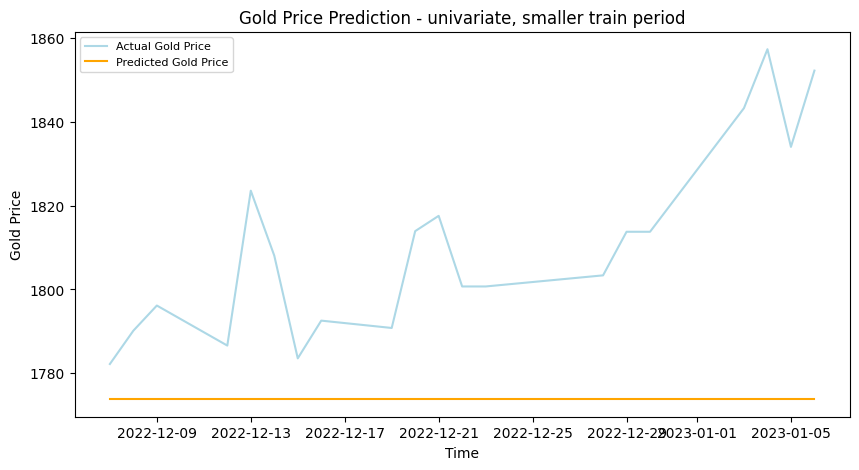

In [ ]:
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(inv_yt, color = 'lightblue', label='Actual Gold Price')
plt.plot(inv_yhgpc[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - univariate, smaller train period')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
g_mae = mean_absolute_error(inv_yt, inv_yhgpc)
g_mape = mean_absolute_percentage_error(inv_yt, inv_yhgpc)
g_mse = mean_squared_error(inv_yt, inv_yhgpc)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 36.402500000000884
MAPE: 0.019969041933883068
MSE: 1799.2823750000648
RMSE: 42.417948736355285


In [ ]:
metric_dict['model'].append('univariate')
metric_dict['no_observations'].append(245)
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

## With explanatory variables

Performing stepwise search to minimize aic


c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1476.424, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1476.791, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1476.381, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1478.421, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1475.822, Time=0.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.334 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 743.210
Date:                Thu, 13 Apr 2023   AIC                          -1478.421
Time:                        22:12:58   BIC                          -1464.774
Sample:                             0   HQIC                         -1472.912
                                - 225                                         
Covariance Type:                  o

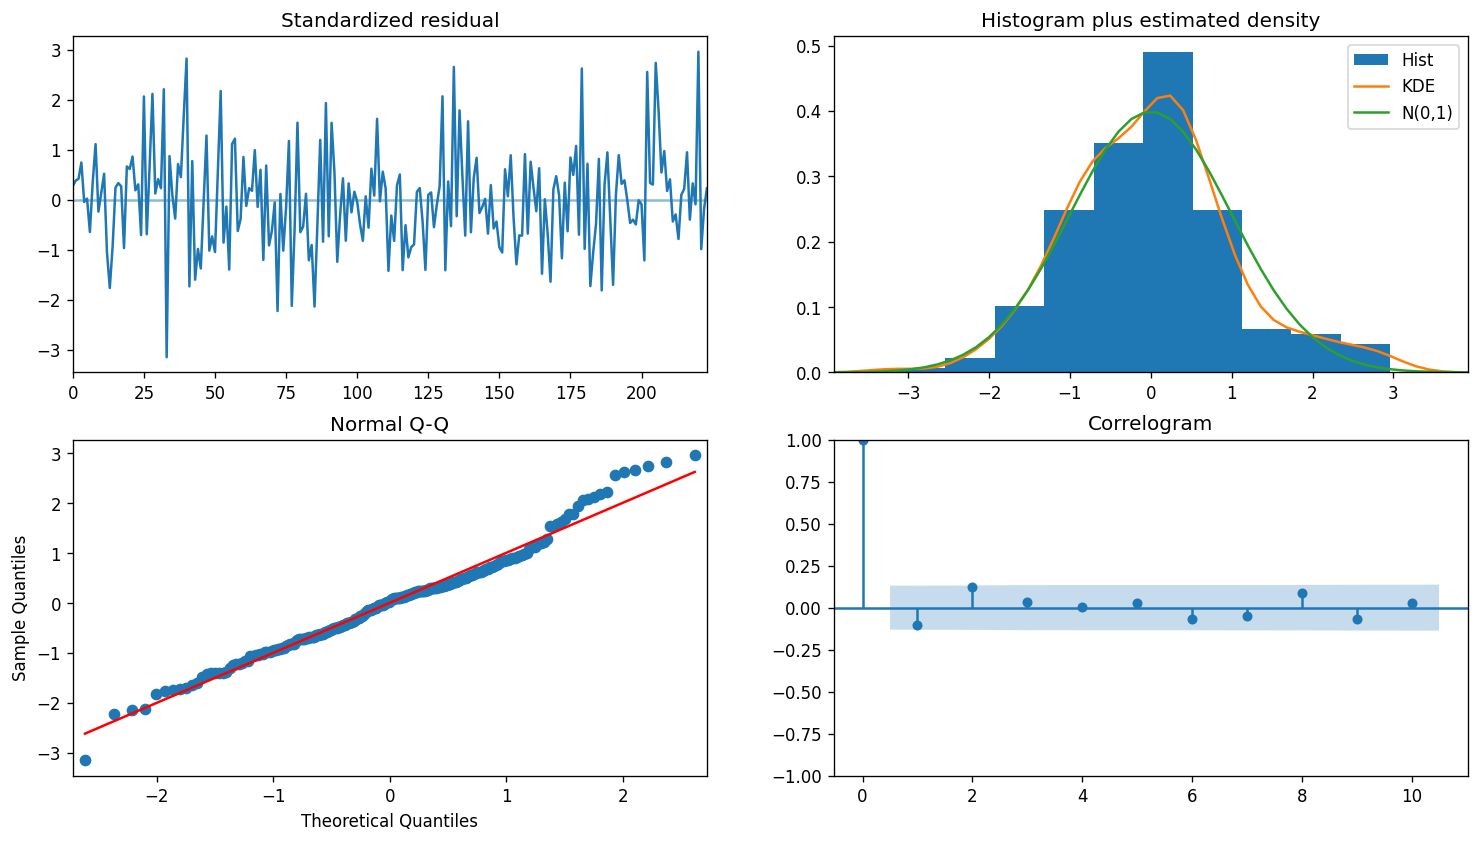

In [ ]:
mvgpcut_autoARIMA = auto_arima(y=y_train, X=X_train, 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=500,
                      scoring='mse',
                      n_jobs=-1)
print(mvgpcut_autoARIMA.summary())
mvgpcut_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
mvgpcut_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 743.210
Date:                Thu, 13 Apr 2023   AIC                          -1478.421
Time:                        22:12:59   BIC                          -1464.774
Sample:                             0   HQIC                         -1472.912
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CrudeOil       0.0974      0.018      5.414      0.000       0.062       0.133
S&P500        -0.0567      0.041     -1.390      0.165      -0.137       0.023
FTSE250        0.0960      0.045      2.135      0.033       0.008       0.184
sigma2      7.676e-05   6.37e-06     12.050      0.000    6.43e-05    8.92e-05
===================================================================================
Ljung-Box (L1) (Q):                   2.40   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.12   Prob(JB):                         0.01
Heteroskedasticity (H):               0.87   Skew:                             0.35
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
y_hat_mvc = mvgpcut_autoARIMA.predict(20,X_test)

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
y_hat_mvc = pd.DataFrame(y_hat_mvc)
y_hat_mvc.index = y_test.index
y_hat_mvc

,0
date,
2022-12-07,7.477091
2022-12-08,7.475267
2022-12-09,7.475811
2022-12-12,7.477100
2022-12-13,7.481294
2022-12-14,7.483565
2022-12-15,7.482676
2022-12-16,7.479541
2022-12-19,7.481488


In [ ]:
inv_ytr = np.exp(y_train)
inv_yt = np.exp(y_test)
inv_yhmvc = np.exp(y_hat_mvc)

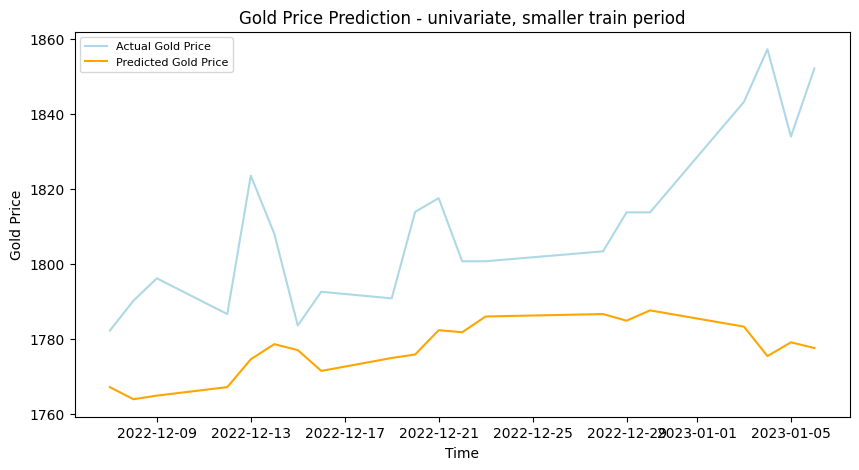

In [ ]:
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(inv_yt, color = 'lightblue', label='Actual Gold Price')
plt.plot(inv_yhmvc[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - univariate, smaller train period')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
g_mae = mean_absolute_error(inv_yt, inv_yhmvc)
g_mape = mean_absolute_percentage_error(inv_yt, inv_yhmvc)
g_mse = mean_squared_error(inv_yt, inv_yhmvc)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 33.23255615780549
MAPE: 0.018235390728133204
MSE: 1513.3328263661804
RMSE: 38.901578713031434


In [ ]:
metric_dict['model'].append('multivariate')
metric_dict['no_observations'].append(245)
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

In [ ]:
metrics_df = pd.DataFrame(metric_dict)
metrics_df['MAE'], metrics_df['MAPE'], metrics_df['MSE'], metrics_df['RMSE'] = round(metrics_df['MAE'],2), round(metrics_df['MAPE'],2), round(metrics_df['MSE'],2), round(metrics_df['RMSE'],2)

metrics_df

,model,no_observations,MAE,MAPE,MSE,RMSE
0,univariate,9149,32.87,0.02,1493.99,38.65
1,multivariate,9149,30.67,0.02,1339.94,36.61
2,univariate,245,36.40,0.02,1799.28,42.42
3,multivariate,245,33.23,0.02,1513.33,38.90
